In [28]:
%%capture
## install dependecies 
!pip install seaborn
!pip install request 
!pip install plotly
!pip install -U scikit-learn

UsageError: Line magic function `%%capture` not found.


# Part 1: Fundamentals of Stress, Strain, and Mechanical Behavior of Materials

## Introduction

In the realm of materials science and mechanics, comprehending how materials react to external forces is paramount. This comprehension forms the foundation for predicting material behavior under various circumstances, which is indispensable for engineering design and analysis. In this section, we will revisit the core concepts of stress, strain, and the mechanical behavior of materials.

## Stress and Strain

**Stress** is a pivotal mechanical property that characterizes a material's internal resistance to deformation when exposed to external forces. It is defined as the force per unit area and signifies the intensity of the internal forces within a material. Stress serves as an indicator of the mechanical load borne by a material and is a critical parameter for assessing its strength and stability.

**Strain**, on the other hand, gauges the amount of deformation a material undergoes in response to applied forces or loads. It quantifies the alteration in size or shape of a material relative to its original dimensions. Strain is typically expressed as the ratio of the change in dimension to the original dimension.

The equations for stress and strain are as follows:

* Stress:

$(\( \sigma \)) = \( \frac{Force (F)}{Area (A)} \)$

* Strain:

$(\( \epsilon \)) = \( \frac{Change\,in\,Length (\Delta L)}{Original\,Length (L)} \)$

## Stress-Strain Relationship

The interconnection between stress and strain is fundamental to grasping how materials perform under load. This relationship is conventionally depicted using a **stress-strain diagram**, a graphical representation of a material's response to escalating stress. The stress-strain diagram provides insights into a material's elastic behavior, yield point, plastic deformation, and ultimate failure.

![Stress-Strain Diagram](Output.png)

## Hooke's Law

One of the primary principles governing the elasticity of materials is **Hooke's Law**, which asserts that the deformation (strain) of a material is directly proportional to the applied stress within the elastic limit. Mathematically, Hooke's Law can be formulated as:

$\[ \sigma = E \cdot \epsilon \]#

$where:
- \( \sigma \) represents the$stress applied to the material.
- \( E \) denotes the Young's Modulus or Elastic Modulus, a material property indicating its stiffness.
- \( \epsilon \) signifies the strain experienced by the material.$

Hooke's Law is a fundamental concept for comprehending the initial behavior of materials within their elastic range. Beyond this point, materials undergo plastic deformation and might not return to their original state upon unloading.



In [29]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'svg')
import requests
import os
import numpy as np
import math
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import pandas as pd 

/tmp/ipykernel_6532/1047729665.py:3: DeprecationWarning:

`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`



In [3]:
# define your values
Force = [0, 4400, 5670, 6600, 7040, 8320, 8800, 9200, 9240]
Elongation = [0, 1, 2, 4, 5, 8, 10, 15, 18]
GLength = 75
Radius = 6.65
LinearLimit = 1

Area = math.pi * Radius * Radius

# stress strain calculated as per above values
Stress = [x * 9.8 / Area for x in Force]
Strain = [x / GLength for x in Elongation]

# True Stress calculation and True Strain calculation

Stress_True = [x * (1 + y) for y, x in zip(Strain, Stress)]
Strain_True = [math.log(1 + x) for x in Strain]

# values created that are needed for interpolation
Strain_values_linear = np.linspace(Strain[0], Strain[LinearLimit], num=41, endpoint=True)
Strain_values_eng = np.linspace(Strain[LinearLimit], Strain[-1], num=41, endpoint=True)
Strain_values_true = np.linspace(Strain_True[LinearLimit], Strain_True[-1], num=41, endpoint=True)

# interpolation defined
f1 = interp1d(Strain, Stress, fill_value='extrapolate')
f2 = interp1d(Strain, Stress, kind=3, fill_value='extrapolate')
f3 = interp1d(Strain_True, Stress_True, kind=3)



In [30]:
fig = go.Figure()

# plot
fig.add_trace(go.Scatter(x=Strain, y=Stress, mode='markers', name='Actual Values'))
fig.add_trace(go.Scatter(x=Strain_values_linear, y=f1(Strain_values_linear), mode='lines', name='Linear Region', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=Strain_values_eng, y=f2(Strain_values_eng), mode='lines', name='Engineering Stress Strain', line=dict(color='green')))
fig.add_trace(go.Scatter(x=Strain_values_true, y=f3(Strain_values_true), mode='lines', name='True Stress Strain', line=dict(color='red')))

# set labels
fig.update_layout(xaxis_title='Strain', yaxis_title='Stress (MPa)')

# define ElasticLimit

ElasticLimit = Stress[LinearLimit]

# define Modulus
Slope = Stress[LinearLimit] / Strain[LinearLimit]
Modulus = Slope / math.pow(10, 3)

# define UTS
uts = max(Stress)
# define Failure Stress

failure_stress = f2(max(Strain))

fig.add_shape(type="line", x0=0, x1=max(Strain), y0=uts, y1=uts, line=dict(color='cyan', dash='dash'))

# plot Ductility Line
fig.add_shape(type="line", x0=Strain[-1], x1=Strain[-1], y0=0, y1=max(Stress), line=dict(color='purple', dash='dash'))

# plot offset Line
xA = [Strain[0], Strain[LinearLimit]]
yA = [Stress[0], Stress[LinearLimit]]
Strain_values_offset = [x + 0.002 * Strain[-1] for x in xA]
f4 = interp1d(Strain_values_offset, yA, fill_value='extrapolate')
Strain_values_offset.append(Strain[LinearLimit + 1])
fig.add_trace(go.Scatter(x=Strain_values_offset, y=f4(Strain_values_offset), mode='lines', name='Offset Line', line=dict(color='orange', dash='dash')))

# find offset yield value
val = Strain[LinearLimit]
step = (Strain[LinearLimit + 1] - Strain[LinearLimit]) / 50
sign = f4(val) - f2(val)
while True:
    if (f4(val) - f2(val)) * sign < 0:
        break
    val = val + step
YieldPoint = f4(val - step)

# plot offset horizontal line
fig.add_shape(type="line", x0=0, x1=max(Strain), y0=YieldPoint, y1=YieldPoint, line=dict(color='black', dash='dash'))

# add legend
fig.update_layout(legend=dict(x=0.7, y=0.98))

annotations = [
    dict(x=Strain[-1], y=max(Stress), xref="x", yref="y", text="Max Strain", showarrow=True, arrowhead=2),
    dict(x=min(Strain), y=uts, xref="x", yref="y", text="UTS", showarrow=True, arrowhead=2),
    dict(x=Strain[-1], y=YieldPoint, xref="x", yref="y", text="Yield Point", showarrow=True, arrowhead=2),
    dict(x=Strain[LinearLimit], y=Stress[LinearLimit], xref="x", yref="y", text="interp1d", showarrow=True, arrowhead=2)
]

anchored_text = f"Young's Modulus = {Modulus:.5f} GPa<br>" \
                f"Elastic Limit = {ElasticLimit:.5f} MPa<br>" \
                f"Yield Stress = {YieldPoint:.5f} MPa<br>" \
                f"UTS = {uts:.5f} MPa<br>" \
                f"Failure Stress = {failure_stress:.5f} MPa<br>" \
                f"Max Strain = {Strain[-1]:.5f}"
fig.add_annotation(go.layout.Annotation(x=0.85, y=0.95, xref="paper", yref="paper", text=anchored_text, showarrow=False))


fig.update_xaxes(range=[0, max(Strain)])
fig.update_yaxes(range=[0, max(Stress)])

fig.update_layout(template="plotly_dark",
     xaxis_title="Strain",
    yaxis_title="Stress (MPa)",
    xaxis_range=[0, max(Strain)],
    yaxis_range=[0, max(Stress)],
    showlegend=True,
    legend=dict(x=1, y=1),
    paper_bgcolor='black', 
    plot_bgcolor='black',             # Set plot area color to black
    font=dict(color='white'),
    width=800,
    height=500
                 )

fig.show()


# Part 2 : We will study a experimental srtess-strain

:## Problem 1 - Analysis of experimental srtess-strain curves of alluminum 6061-T651

We are going to analyze the dataset collected by {cite}`AAKASH2019104085`.
They perform two types of experiments.
We are going to focus on the "uniaxial tension experiment." 
This is what it is all about:
+ They take several speciments of alluminum 6061-T651 (https://data.mendeley.com/datasets/rd6jm9tyb6/2).
+ The shape of these speciments is like this:

```{figure} https://ars.els-cdn.com/content/image/1-s2.0-S2352340919304391-gr1_lrg.jpg
---
height: 300px
name: directive-fig
---
Geometry of the uniaxial tension specimen.
```
+ They mounted the speciment (using the holes you see on the sides) on a machine that applied tension:

```{figure} https://ars.els-cdn.com/content/image/1-s2.0-S2352340919304391-gr5_lrg.jpg
---
height: 300px
name: directive-fig2
---
The mounted specimen.
```
+ They controlled the temperature of the specimen.
+ They applied tension gradually until the speciment broke, recorging at each step the strain (% change in length) and the stress (force per cross section area in MPa - megaPascal).

I suggest that you skim through the paper if you want to understand more about the details of the experiment.
Measuring the strains and stresses is not as straightforward as it sounds...

Our goal is to download the data, and for a fixed temperature, create a model for the stress-strain relation.

In [6]:
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

/tmp/ipykernel_6532/3079952530.py:8: DeprecationWarning:

`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`



In [ ]:
url = "https://data.mendeley.com/public-files/datasets/rd6jm9tyb6/files/559cd828-c044-418a-837c-35ce161c02ab/file_downloaded"

download(url)

In [ ]:
!mkdir stress-strain-curves-of-aluminum

In [ ]:
!unzip -o file_downloaded -d stress-strain-curves-of-aluminum


In [7]:

df_1= pd.read_csv("stress-strain-curves-of-aluminum/P_020_G_2_022_195_24.csv")
df_2 = pd.read_csv("stress-strain-curves-of-aluminum/P_200_G_3_116_171_07.csv")


print(f"the mean and STD of Stress of all the distrubtion are : \n Mean {df_1['Strain'].mean()} \n and Std : {df_1['Strain'].std()}")

df_2.head(7)


the mean and STD of Stress of all the distrubtion are : 
 Mean 0.045705060425004475 
 and Std : 0.07287014190974071


In [ ]:
combined_df = pd.concat([df_1, df_2], ignore_index=True)
combined_df.head(3)

In [8]:
# Calculate Young's Modulus, Elastic Limit, and Yield Stress
# Using the first data point
# Using the minimum stress value

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_1['Strain'], y=df_1['Stress_MPa'], mode='markers', name='Data Points'))

# Calculate Young's Modulus, Elastic Limit, and Yield Stress
ElasticLimit = df_1['Stress_MPa'][0]
Modulus = ElasticLimit / df_1['Strain'][0]  # Using the first data point
# Using the minimum stress value
YieldPoint = df_1['Stress_MPa'].min() 

annot_propties  = f"Young's Modulus = {Modulus:.5f} GPa<br>" \
             f"Elastic Limit = {ElasticLimit:.5f} MPa<br>" \
             f"Yield Stress = {YieldPoint:.5f} MPa"
fig.add_annotation(x=0, y=max(df_1['Stress_MPa']), text=annot_propties, align="right", showarrow=False)

# Set labels and title
fig.update_layout(
    xaxis_title='Strain',
    yaxis_title='Stress (MPa)',
    title='Stress-Strain Relationship',
    plot_bgcolor='white',  
    legend=dict(x=0.7, y=0.98)  
)

fig.show()


In [9]:
figures = []

# Function to create the plot and annotations
def create_plot(df, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['Strain'], y=df['Stress_MPa'], mode='markers', name='Data Points'))

    ElasticLimit = df['Stress_MPa'][0]
    Modulus = ElasticLimit / df['Strain'][0]
    YieldPoint = df['Stress_MPa'].min()

    annot_text = f"Young's Modulus = {Modulus:.5f} GPa<br>" \
                 f"Elastic Limit = {ElasticLimit:.5f} MPa<br>" \
                 f"Yield Stress = {YieldPoint:.5f} MPa"
    fig.add_annotation(x=0, y=max(df['Stress_MPa']), text=annot_text, align="left", showarrow=False)

    fig.update_layout(
        xaxis_title='Strain',
        yaxis_title='Stress (MPa)',
        title=title,
        plot_bgcolor='white',
        legend=dict(x=0.7, y=0.98)
    )
    return fig

fig_1 = create_plot(df_1, 'Stress-Strain Relationship - DataFrame 1')
figures.append(fig_1)

fig_2 = create_plot(df_2, 'Stress-Strain Relationship - DataFrame 2')
figures.append(fig_2)

for fig in figures:
    fig.show()

#### estimate the relationship between stress and strain using a Linear model

* To estimate the relationship between stress and strain dataFrame 1
  1. we can calculate the Young's Modulus using linear regression. Young's Modulus represents
   the stiffness of a material and is defined as the ratio of stress to strain within the elastic limit.
    2. Let's estimate Young's Mo# Predicting Deformable Point using Polynomial Regression





In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler


### Method 1 Linear model 

##### Data Scaling

To ensure accurate and effective model training, the stress and strain data are scaled using the `StandardScaler` technique. Scaling transforms the data into a standardized format, ensuring that they are on a comparable scale for regression analysis.

##### Linear Regression Model

A linear regression model is then employed to capture the relationship between scaled strain and scaled stress. The linear regression equation takes the form:

$\[ \text{stress} = a \cdot \text{strain} + b \]$

Here, $ a $ represents the slope of the best-fitting line, $and  b  $is the intercept

##### Model Fitting

The linear regression model aims to find the values of $\( a \) and \( b \)$ 

that minimize the difference between the predicted stress and the actual stress values. This process is known as model fitting

##### Calculating Young's Modulus

Young's Modulus $(\( E \))$ represents the measure of a material's stiffness. It is calculated as the ratio of stress to strain within the linear elastic region. In the context of linear regression, \( E \) is equivalent to the slope (\( a \)) of the fitted line.

The estimated Young's Modulus $(\( E_{\text{estimated}} \))$ is obtained from the coefficient $\( a \)$ of the linear regression model. To obtain the Young's Modulus in its original units, we perform an inverse transform using the scaling factors.

In [16]:
df_1 = pd.read_csv("stress-strain-curves-of-aluminum/P_020_G_2_022_195_24.csv")

stress = df_1['Stress_MPa'].values
strain = df_1['Strain'].values

scaler = StandardScaler()
stress_scaled = scaler.fit_transform(stress.reshape(-1, 1)).flatten()
strain_scaled = scaler.fit_transform(strain.reshape(-1, 1)).flatten()

strain_2d = strain_scaled.reshape(-1, 1)

model = LinearRegression()
model.fit(strain_2d, stress_scaled)

# Calculate Young's Modulus (slope of the linear fit)
youngs_modulus_scaled = model.coef_[0]

print("Estimated Young's Modulus:", youngs_modulus, "MPa")


Estimated Young's Modulus: 719.040715451843 MPa


## Methods 2  : Polynomial Regression

##### Data Preparation

The process begins with the collection of stress-strain data from experimental tests. The collected data is then preprocessed by scaling both the stress and strain values using the StandardScaler technique. Scaling ensures that the data is on a comparable scale, which is important for accurate model training and predictions.

##### Polynomial Regression Model

To predict the stress at the next deformable point on the strain-stress curve, a polynomial regression model is employed. This model fits a polynomial equation to the scaled stress and strain data. In this example, we use a second-degree polynomial.

$\[
\text{stress} = a_0 + a_1 \cdot \text{strain} + a_2 \cdot \text{strain}^2
\]$

Here, $\(a_0\), \(a_1\), and \(a_2\)$ are the coefficients of the polynomial equation, which are determined through model training.


## Results

![Predicting Deformable Point using Polynomial Regression](example-polynomial-regression-prediction.png)


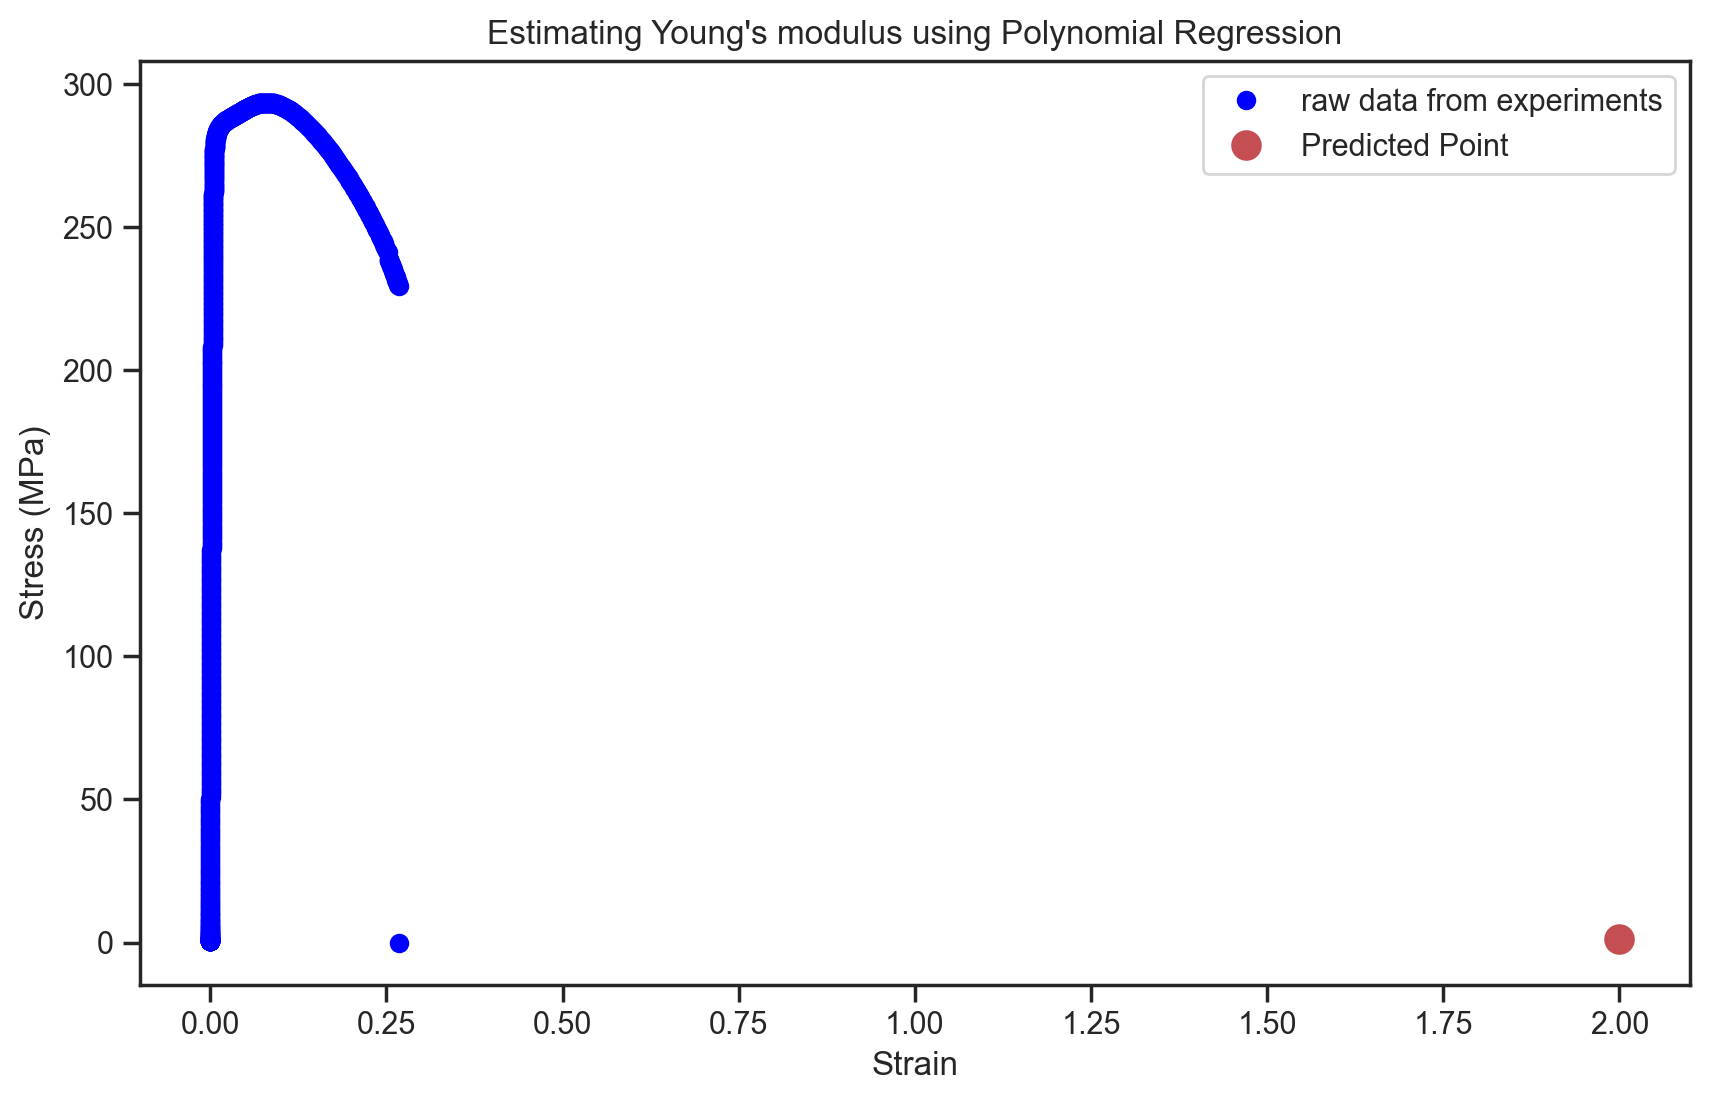

Predicted Stress at Next Deformable Point: 0.12518793330687533 MPa


In [22]:
stress = df_1['Stress_MPa'].values
strain = df_1['Strain'].values

scaler = StandardScaler()
stress_scaled = scaler.fit_transform(stress.reshape(-1, 1)).flatten()
strain_scaled = scaler.fit_transform(strain.reshape(-1, 1)).flatten()

strain_2d = strain_scaled.reshape(-1, 1)

# Use PolynomialFeatures to transform the features
poly = PolynomialFeatures(degree=2)
strain_poly = poly.fit_transform(strain_2d)

model = LinearRegression()
model.fit(strain_poly, stress_scaled)

# Predict the next deformable point on the strain-stress curve
next_strain_scaled = np.array([[2.0]])  # Adjust the desired strain value
next_strain_poly = poly.transform(next_strain_scaled)
predicted_stress_scaled = model.predict(next_strain_poly)

# Inverse transform to get predicted stress in original units
predicted_stress = scaler.inverse_transform([predicted_stress_scaled])[0][0]

plt.figure(figsize=(10, 6))
plt.plot(strain, stress, 'o', linewidth=0, label='raw data from experiments', color='blue')
plt.plot(next_strain_scaled, predicted_stress_scaled, 'ro', markersize=10, label='Predicted Point')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title("Estimating Young's modulus using Polynomial Regression")
plt.legend()

# Save the plot
plt.savefig("example-polynomial-regression-prediction.png")

plt.show()

print("Predicted Stress at Next Deformable Point:", predicted_stress, "MPa")
